<a href="https://colab.research.google.com/github/SebaCarrilloS/Formacion-Data-Science/blob/main/Prediccion_Ventas_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Desafío 6 - Aprendizaje supervisado y no supervisado (Parte V)**

Nombre: Sebastián Carrillo

Curso: Machine Learning (G80)

**Descripción**

En esta tarea, se te presenta el desafiante escenario de predecir las ventas mensuales de una tienda utilizando técnicas de análisis de series de tiempo. El objetivo principal es aplicar un enfoque riguroso de análisis y modelado de series de tiempo para realizar predicciones precisas de las ventas futuras.

La tienda ha recopilado datos históricos de ventas mensuales durante varios años, en el archivo `Sales_Data.xlsx`. Tu tarea es desarrollar un modelo que sea capaz de predecir las ventas mensuales futuras basándose en estos datos.

Pasos a Realizar:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
sns.set(style="ticks")

# 1. Descomposición de la Serie de Tiempo: Comienza descomponiendo la serie de tiempo en sus componentes principales: tendencia, estacionalidad y residuos. Utiliza métodos como el suavizamiento exponencial o la descomposición estacional para comprender la estructura subyacente de los datos.

In [2]:
df=pd.read_excel("/content/drive/MyDrive/Formación Data Science/Desafío Latam/Módulo 5 - Machine Learning/Desafios/Desafio 6/Sales_Data.xlsx")
df.head()

,Order Date,Sales
0,2015-01-01,14205.707
1,2015-02-01,4519.892
2,2015-03-01,55205.797
3,2015-04-01,27906.855
4,2015-05-01,23644.303


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Order Date  48 non-null     datetime64[ns]
 1   Sales       48 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 896.0 bytes


In [4]:
df.set_index('Order Date', inplace=True)


In [5]:
df.index.freq = 'MS'

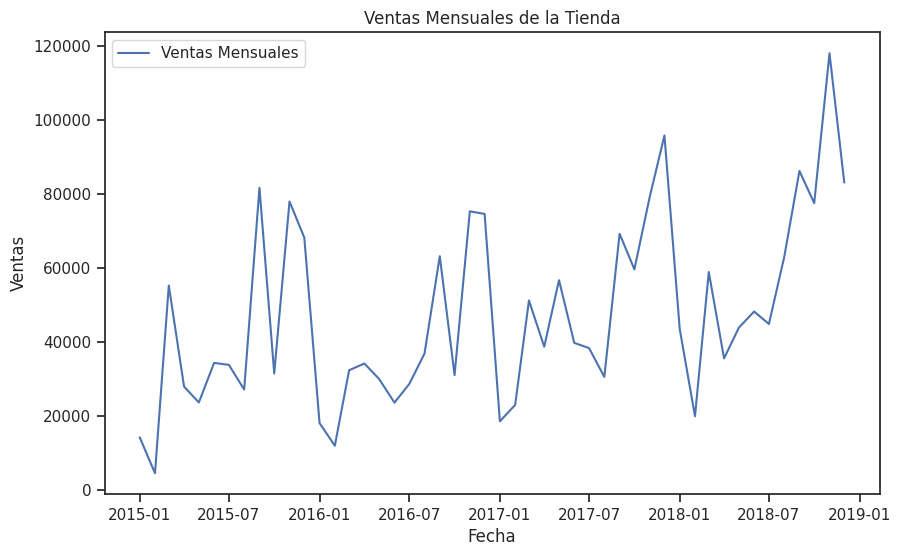

In [6]:
plt.figure(figsize=(10,6))
plt.plot(df['Sales'], label='Ventas Mensuales')
plt.title('Ventas Mensuales de la Tienda')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()

Aplicamos modelo aditivo para este caso.

In [7]:
decomposition = seasonal_decompose(df['Sales'], model='additive')

<Figure size 1000x800 with 0 Axes>

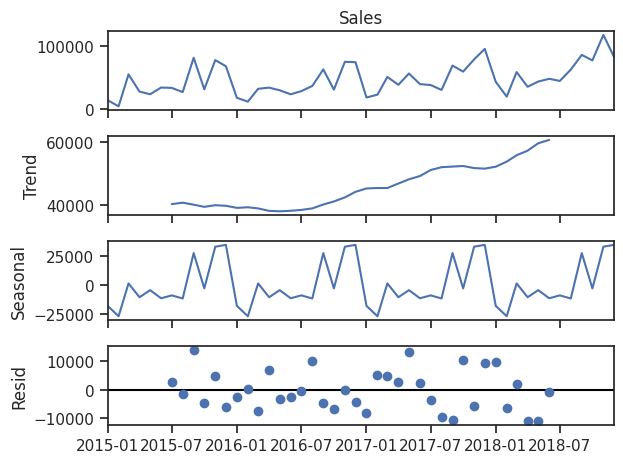

In [8]:
plt.figure(figsize=(10,8))
decomposition.plot()
plt.show()

## Resumen:

*  Se puede ver una tendencia al alza de las ventas solicitadas, que se ve más hacia el final del período
*  También se puede ver una fuerte estacionalidad en los datos, con variaciones predecibles a lo largo del año.
*  De los residuos, estos apuntan a la presencia de variabilidad no explicada por los modelos, lo que podría requerir un análisis más profundo de factores externos o eventos imprevistos


# 2. Identificación de Parámetros ARIMA: Utiliza las funciones de autocorrelación (ACF) y autocorrelación parcial (PACF) para identificar los posibles valores de los parámetros p (orden del término autorregresivo) y q (orden del término de media móvil) en en modelo ARIMA. Además, realiza el test de Dickey-Fuller para determinar si es necesario aplicar la diferenciación (valor d) para lograr la estacionaridad.

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

Text(0.5, 1.0, 'PACF - Autocorrelación Parcial')

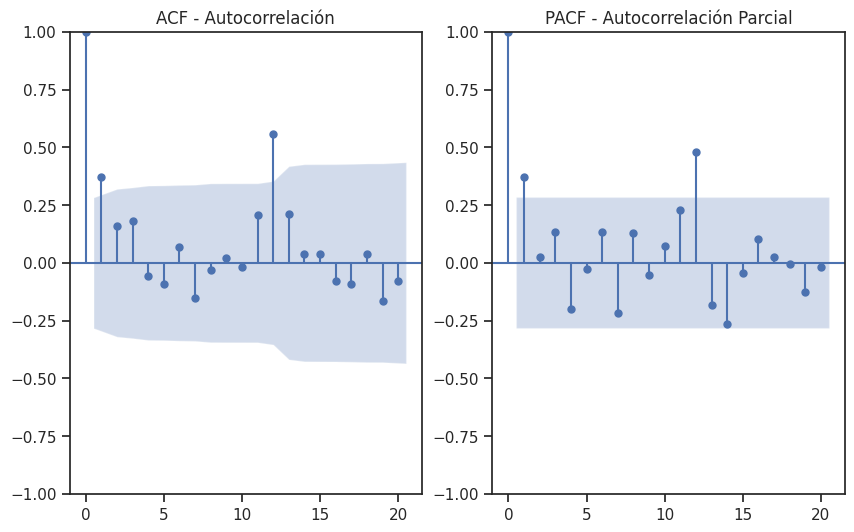

In [10]:
#Gráfico ACF (autocorrelación)
plt.figure(figsize=(10,6))
plt.subplot(121)
plot_acf(df['Sales'], lags=20, ax=plt.gca())
plt.title('ACF - Autocorrelación')

# Gráfico PACF (autocorrelación parcial)
plt.subplot(122)
plot_pacf(df['Sales'], lags=20, ax=plt.gca())
plt.title('PACF - Autocorrelación Parcial')

In [11]:
def adf_test(series,title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data

    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val

    print(out.to_string())          # .to_string() removes the line "dtype: float64"

    if result[1] <= 0.05:
        print("Fuerte evidencia en contra de la hipótesis nula")
        print("Se rechaza la hipótesis nula")
        print("Los datos no tienen raíz unitaria y son estacionarios")
    else:
        print("Débil evidencia en contra de la hipótesis nula")
        print("No se puede rechazar la hipótesis nula")
        print("Los datos tienen raíz unitaria y son no estacionarios")

In [12]:
adf_test(df['Sales'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -4.416137
p-value                  0.000278
# lags used              0.000000
# observations          47.000000
critical value (1%)     -3.577848
critical value (5%)     -2.925338
critical value (10%)    -2.600774
Fuerte evidencia en contra de la hipótesis nula
Se rechaza la hipótesis nula
Los datos no tienen raíz unitaria y son estacionarios


Se tiene de gráficos que:

*  $p = 1$: Debido al primer valor significativo en el PACF y al descenso gradual.
*  $q = 1$: Debido al corte abrupto después del rezago 1 en el ACF.



## Resumen:

*  Dada la prueba de Dickey-Fuller, se considera que el modelo es estacionario.
*  El gráfico PACF muestra un primer valor significativo, sugiriendo un posible valor de $𝑝=1$
*  $q$ (orden de media móvil): El gráfico ACF muestra un corte abrupto después del rezago 1, sugiriendo que $q=1$
*  Por lo tanto, el modelo Arima propuesto es $ARIMA(1,0,1)$

# 3. Modelado con ARIMA: Aplica el modelo ARIMA utilizando los parámetros identificados en el paso anterior. Ajusta el modelo a los datos históricos de ventas mensuales y realiza predicciones para los próximos meses.

In [13]:
from statsmodels.tsa.arima.model import ARIMA
p=1
d=0
q=1

In [14]:
model = ARIMA(df['Sales'], order=(p, d, q))
model_fit = model.fit()

In [15]:
forecast = model_fit.forecast(steps=12)
forecast

,predicted_mean
2019-01-01,69307.252030
2019-02-01,61884.374751
2019-03-01,56944.344871
2019-04-01,53656.685073
2019-05-01,51468.700950
2019-06-01,50012.566551
2019-07-01,49043.488502
2019-08-01,48398.553345
2019-09-01,47969.339871
2019-10-01,47683.692229


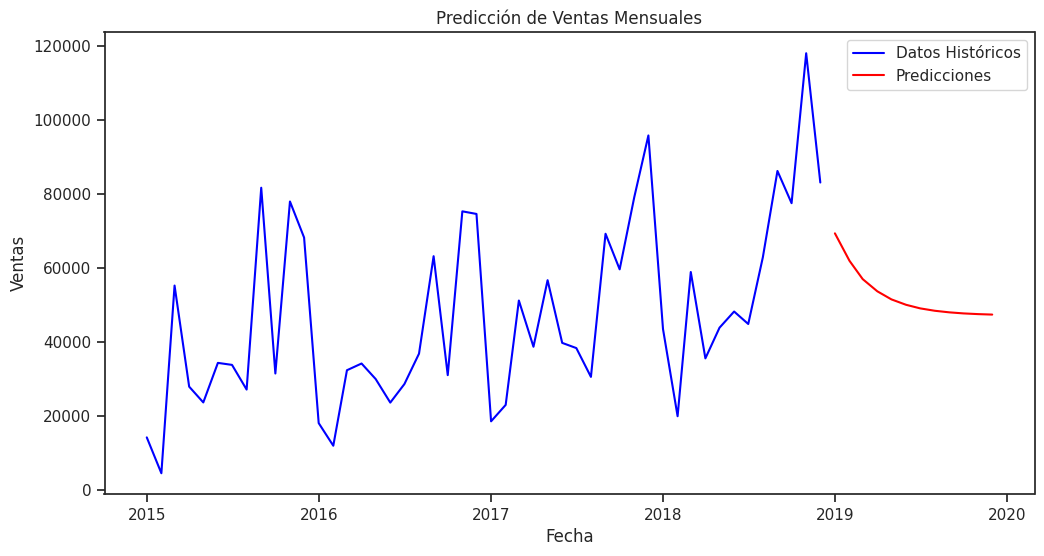

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(df['Sales'], label='Datos Históricos', color='blue')
plt.plot(pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=12, freq='MS'), forecast, label='Predicciones', color='red')
plt.title('Predicción de Ventas Mensuales')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()

# 4. Evaluación de Predicciones: Divide los datos históricos en un conjunto de entrenamiento y uno de prueba. Utiliza el conjunto de entrenamiento para ajustar el modelo ARIMA y luego evalúa las predicciones en el conjunto de prueba. Calcula métricas de evaluación como el error cuadrático medio (MSE) o el error absoluto medio (MAE) para medir el rendimiento del modelo.

In [18]:
train_size = int(len(df) * 0.75)
train, test = df.iloc[:train_size], df.iloc[train_size:]

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [20]:
rmse = np.round(np.sqrt(mean_squared_error(test['Sales'], forecast)),2)
mae = np.round(mean_absolute_error(test['Sales'], forecast),2)

In [21]:
print(f'MSE: {rmse}')
print(f'MAE: {mae}')

MSE: 31126.37
MAE: 24167.18


## Conclusiones:
*  Ambos valores (MSE y MAE) sugieren que hay un margen significativo de error en las predicciones. Si bien no existen valores "buenos" o "malos" para MSE y MAE fuera de un contexto específico, en este caso, la magnitud del error indica que el modelo puede beneficiarse de mejoras adicionales.
*  Una sugerencia para mejorar las predicciones es probar otros valores de p, d, q:, ya que el modelo ARIMA(1,0,1) se seleccionó con base en ACF y PACF, pero experimentar con otros valores podría mejorar las predicciones.
